In [1]:
import pandas as pd

df = pd.read_json('result_data.json')

In [2]:
from datetime import datetime

def change_time(dt):
    return datetime.fromtimestamp(dt//1000)

df['fetchdate_orig'] = df['fetchdate_orig'].apply(change_time)
df['fetchdate_check'] = df['fetchdate_check'].apply(change_time)

In [3]:
start_date = datetime.strptime("24-02-2022", "%d-%m-%Y")
end_date = datetime.strptime("24-03-2022", "%d-%m-%Y")
df_war = df[(df['fetchdate_check'] >= start_date) & (df['fetchdate_check'] <= end_date)]

In [7]:
df_test = df_war['page_title'].to_frame().reset_index()
df_test.drop(['index'], axis=1).to_csv('test.csv')

In [22]:
import re
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

In [24]:
stopwords = stopwords.words('russian')

In [25]:
bad_words = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_{|}~\"\-]+"
morph = MorphAnalyzer()

def token_only(text):
    text = re.sub(bad_words,' ',text)
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        token = token.strip()
        token = morph.normal_forms(token)[0]
        filtered_tokens.append(token)
    return filtered_tokens


dfclall = df_test['page_title']
stopwords.extend(["и", "в", "во", "не", "что", "он", "на", "я", "с", "со", "как", "а", "то", "все", "она", "так", "его",
"но", "да", "ты", "к", "у", "же", "вы", "за", "бы", "по", "только", "ее", "мне", "было", "вот", "от", "меня", "еще",
"нет", "о", "из", "ему", "теперь", "когда", "даже", "ну", "вдруг", "ли", "если", "уже", "или", "ни", "быть", "был",
"него", "до", "вас", "нибудь", "опять", "уж", "вам", "ведь", "там", "потом", "себя", "ничего", "ей", "может", "они",
"тут", "где", "есть", "надо", "ней", "для", "мы", "тебя", "их", "чем", "была", "сам", "чтоб", "без", "будто", "чего",
"раз", "тоже", "себе", "под", "будет", "ж", "тогда", "кто", "этот", "того", "потому", "этого", "какой", "совсем",
"ним", "здесь", "этом", "один", "почти", "мой", "тем", "чтобы", "нее", "сейчас", "были", "куда", "зачем", "всех",
"никогда", "можно", "при", "наконец", "два", "об", "другой", "хоть", "после", "над", "больше", "тот", "через", "эти",
"нас", "про", "всего", "них", "какая", "много", "разве", "три", "эту", "моя", "впрочем", "хорошо", "свою", "этой",
"перед", "иногда", "лучше", "чуть", "том", "нельзя", "такой", "им", "более", "всегда", "конечно", "всю", "между", 'иза'])


tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,max_df=0.6,min_df=0.01,max_features=100000,
                                   stop_words=stopwords, use_idf=True,tokenizer=token_only, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(dfclall)

/Users/bobenkom/Desktop/GitHub/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['большой', 'весь', 'всё', 'ещё', 'мочь', 'нибыть', 'свой', 'хороший', 'это'] not in stop_words.
  warnings.warn(


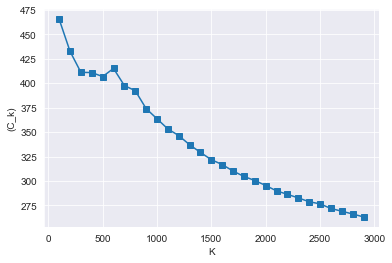

In [28]:
inertia = []
for k in range(100,3000,100):
    mbk  = MiniBatchKMeans(n_clusters=k,init='random', random_state=1).fit(tfidf_matrix)
    inertia.append(np.sqrt(mbk.inertia_))
plt.plot(range(100,3000,100),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

In [29]:
mbk = MiniBatchKMeans(n_clusters=600,init='random').fit(tfidf_matrix)
y_kmeansMBK = mbk.predict(tfidf_matrix)
Num = []
Num = [pt for pt in y_kmeansMBK]
df2 = {"Num_Cluster": Num}
dfMBK = pd.DataFrame(df2)

df = pd.concat([df_test,dfMBK], axis=1)

In [30]:
df

,index,page_title,Num_Cluster
0,1682792,Segezha потеснит фанерщиков,0
1,1682793,Интервью президента Segezha Group Камиля Закирова,317
2,1682794,Интервью руководителя проектов компании Ledine...,8
3,1682795,"Статьи автора Алексей Богатырев в журнале ""Лес...",0
4,1682796,ЛПК остался без стратегии,0
...,...,...,...
1038144,3872470,"Уральский экономист рассказал, как изменятся ц...",79
1038145,3872471,Возле югорского города начался отстрел волков ...,0
1038146,3872472,"Депутат считает, что Соцфонд должен контролиро...",52
1038147,3872473,"«В Брюсселе говорили, что нужно давать Нобелев...",285
